# Test daily reward loss
Test the new model to check if it is working correctly.

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
import os 
#os.environ['MPLCONFIGDIR'] = "$HOME"
#os.envir
# on["WANDB_DIR"] = os.path.join(os.path.dirname(__file__), "..", "wandb")
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), os.path.pardir)))
# sys append 
sys.path.append("..")
from data import BavarianCrops, BreizhCrops, SustainbenchCrops, ModisCDL
from torch.utils.data import DataLoader
from models.earlyrnn import EarlyRNN
from models.daily_earlyrnn import DailyEarlyRNN
import torch
from tqdm import tqdm
from utils.losses.early_reward_loss import EarlyRewardLoss
from utils.losses.stopping_time_proximity_loss import StoppingTimeProximityLoss, sample_three_uniform_numbers
from utils.losses.daily_reward_loss import DailyRewardLoss
from utils.losses.loss_helpers import log_class_prob_at_t_plus_zt
from utils.losses.classification_loss import ClassificationLoss
from utils.losses.daily_reward_lin_regr_loss import DailyRewardLinRegrLoss
import sklearn.metrics
import pandas as pd
import wandb
from utils.plots import plot_label_distribution_datasets, boxplot_stopping_times
from utils.doy import get_doys_dict_test, get_doy_stop, create_sorted_doys_dict_test, get_approximated_doys_dict
from utils.helpers_training import parse_args_sweep, train_epoch
from utils.helpers_testing import test_epoch
from utils.metrics import harmonic_mean_score
from models.model_helpers import count_parameters, get_t_stop_from_daily_timestamps
import matplotlib.pyplot as plt


## Test the loss

In [21]:
# config 
class Config():
    def __init__(self):
        self.alpha = 0.9
        self.backbonemodel = "LSTM"
        self.batchsize = 256
        self.corrected = True
        self.dataroot = os.path.join(os.environ.get("HOME", os.environ.get("USERPROFILE")),"elects_data")
        self.dataset = "breizhcrops"
        self.device = "cuda"
        self.epochs = 100
        self.epsilon = 10
        self.extra_padding_list = [0]
        self.hidden_dims = 64
        self.learning_rate = 0.001
        self.loss_weight = "balanced"
        self.patience = 30
        self.resume = False
        self.sequencelength = 365
        self.validation_set = "valid"
        self.weight_decay = 0
        self.daily_timestamps = True
        self.original_time_serie_lengths = [102]
        self.loss = "daily_reward_lin_regr"
        self.day_head_init_bias = 5
        self.decision_head = "day"
        self.start_decision_head_training = 0
        self.alpha_decay = [.9, 0.8]
        
config = Config()

In [7]:
dataroot = os.path.join(config.dataroot,"breizhcrops")
input_dim = 13
test_ds = BreizhCrops(root=dataroot,partition=config.validation_set, sequencelength=config.sequencelength, corrected=config.corrected, daily_timestamps=config.daily_timestamps, original_time_serie_lengths=config.original_time_serie_lengths)
train_ds = BreizhCrops(root=dataroot,partition="train", sequencelength=config.sequencelength, corrected=config.corrected, daily_timestamps=config.daily_timestamps, original_time_serie_lengths=config.original_time_serie_lengths)
nclasses = train_ds.nclasses
class_names = train_ds.labels_names
traindataloader = DataLoader(train_ds,batch_size=config.batchsize)
testdataloader = DataLoader(test_ds, batch_size=config.batchsize)

2559635960 2559635960


loading data into RAM: 100%|██████████| 67523/67523 [00:29<00:00, 2318.03it/s]


2253658856 2253658856


loading data into RAM: 100%|██████████| 85310/85310 [00:34<00:00, 2455.38it/s]


cost function: 

model: 

In [22]:
model = DailyEarlyRNN(config.backbonemodel, nclasses=nclasses, input_dim=input_dim, sequencelength=config.sequencelength, hidden_dims=config.hidden_dims).to(config.device)


optimizer

In [23]:
# exclude decision head linear bias from weight decay
decay, no_decay = list(), list()
for name, param in model.named_parameters():
    if name == "stopping_decision_head.projection.0.bias":
        no_decay.append(param)
    else:
        decay.append(param)

optimizer = torch.optim.AdamW([{'params': no_decay, 'weight_decay': 0, "lr": config.learning_rate}, {'params': decay}],
                                lr=config.learning_rate, weight_decay=config.weight_decay)



In [27]:
import torch
from torch import nn
from utils.losses.loss_helpers import probability_correct_class, log_class_prob_at_t_plus_zt

class DailyRewardLinRegrLoss(nn.Module):
    def __init__(self, alpha:float=1., weight=None, alpha_decay: list=None, epochs: int=100, start_decision_head_training: int=0, mu: float=150.):
        """_summary_

        Args:
            alpha (float, optional): _description_. Defaults to 0.5.
            weight (list, optional): weight for each class, shape: (nclasses). Defaults to None.
            alpha_decay (list, optional): contains [alpha_decay_max, alpha_decay_min]. Through the epochs, starts at alpha_decay_max
                        and get closer to alpha_decay_min. Defaults to None.
            epochs (int, optional): number of epochs. Defaults to 100.
            start_decision_head_training (int, optional): epoch to start training the decision head. Defaults to 0.
        """
        super(DailyRewardLinRegrLoss, self).__init__()

        self.weight = weight
        self.negative_log_likelihood = nn.NLLLoss(reduction="none", weight=self.weight)
        self.alpha = alpha
        
        if alpha_decay is not None:
            self.alpha_decay_max = alpha_decay[0]
            self.alpha_decay_min = alpha_decay[1]
            self.epochs = epochs
        
        self.start_decision_head_training = start_decision_head_training
        self.mu = mu
            

    def forward(self, log_class_probabilities, timestamps_left, y_true, return_stats=False, **kwargs):
        N, T, C = log_class_probabilities.shape
        epoch = kwargs.get("epoch", 0)

        # equation 4, right term
        t = torch.ones(N, T, device=log_class_probabilities.device) * \
                torch.arange(T).type(torch.FloatTensor).to(log_class_probabilities.device)
        log_class_probabilities_at_t_plus_zt = log_class_prob_at_t_plus_zt(log_class_probabilities, timestamps_left)

        # compute alpha
        if hasattr(self, "alpha_decay_max"):
            if epoch >= self.start_decision_head_training:
                # alpha goes from alpha_decay_max to alpha_decay_min linearly
                self.alpha = self.alpha_decay_min + (self.alpha_decay_max - self.alpha_decay_min) * \
                    (1 - (epoch-self.start_decision_head_training)/(self.epochs-self.start_decision_head_training))
                            
        # earliness reward and linear regression loss
        if epoch>=self.start_decision_head_training and self.alpha<1.-1e-8:
            earliness_reward = probability_correct_class(log_class_probabilities_at_t_plus_zt, y_true, weight=self.weight) * (1-t/T) * (1-timestamps_left.float()/T)
            earliness_reward = earliness_reward.sum(1).mean(0)
            
            lin_regr_zt_loss = lin_regr_zt(t, T, self.mu, timestamps_left.float())
            lin_regr_zt_loss = lin_regr_zt_loss.sum(1).mean(0)
            print("lin_regr_zt_loss", lin_regr_zt_loss)
        else:
            # if the decision head is not trained, the earliness reward is zero
            earliness_reward = torch.tensor(0.0, device=log_class_probabilities.device) 
            lin_regr_zt_loss = torch.tensor(0.0, device=log_class_probabilities.device)
            
        # classification loss
        cross_entropy = self.negative_log_likelihood(log_class_probabilities.view(N*T,C), y_true.view(N*T)).view(N,T)
        classification_loss = cross_entropy.sum(1).mean(0)

        # final loss
        loss = self.alpha*classification_loss - (1.-self.alpha/2.)*earliness_reward + (1.-self.alpha/2.)*lin_regr_zt_loss

        if return_stats:
            stats = dict(
                classification_loss=classification_loss.cpu().detach().numpy(),
                earliness_reward=earliness_reward.cpu().detach().numpy(),
                timestamps_left=timestamps_left.cpu().detach().numpy(),
                lin_regr_zt_loss=lin_regr_zt_loss.cpu().detach().numpy(),
            )
            return loss, stats
        else:
            return loss
        

def lin_regr_zt(t, T, mu, z_t):
    print("t.shape", t.shape)
    print("T", T)
    print("mu", mu)
    print("z_t", z_t.shape)
    result = (mu-t-z_t)/T
    print("result.shape", result.shape)
    return ((mu-t-z_t)/T)**2


loss: 

In [28]:
if config.loss_weight == "balanced":
    class_weights = train_ds.get_class_weights().to(config.device)
else: 
    class_weights = None

if config.loss == "early_reward":
    criterion = EarlyRewardLoss(alpha=config.alpha, epsilon=config.epsilon, weight=class_weights)
elif config.loss == "stopping_time_proximity":
    criterion = StoppingTimeProximityLoss(alphas=config.alphas, weight=class_weights)
elif config.loss == "daily_reward_loss":
    criterion = DailyRewardLoss(alpha=config.alpha, weight=class_weights)
elif config.loss == "classification_loss":
    criterion = ClassificationLoss(weight=class_weights)
elif config.loss == "daily_reward_lin_regr":
    criterion = DailyRewardLinRegrLoss(alpha=config.alpha, weight=class_weights, alpha_decay=config.alpha_decay, epochs=config.epochs, start_decision_head_training=config.start_decision_head_training)
else: 
    raise ValueError("Loss not implemented")

Train example

In [29]:
# ----------------------------- TRAINING -----------------------------
start_epoch = 1
print("starting training...")
with tqdm(range(start_epoch, config.epochs + 1)) as pbar:
    for epoch in pbar:
        trainloss = train_epoch(model, traindataloader, optimizer, criterion, device=config.device)
        testloss, stats = test_epoch(model, testdataloader, criterion, config.device, return_id=test_ds.return_id, daily_timestamps=config.daily_timestamps)
        break
    
        # plot timestamps left
        fig_timestamps, ax_timestamps = plt.subplots(figsize=(15, 7))
        plot_timestamps_left(stats, ax_timestamps, fig_timestamps)
        
        # statistic logging and visualization...
        precision, recall, fscore, support = sklearn.metrics.precision_recall_fscore_support(
            y_pred=stats["predictions_at_t_stop"][:, 0], y_true=stats["targets"][:, 0], average="macro",
            zero_division=0)
        accuracy = sklearn.metrics.accuracy_score(
            y_pred=stats["predictions_at_t_stop"][:, 0], y_true=stats["targets"][:, 0])
        kappa = sklearn.metrics.cohen_kappa_score(
            stats["predictions_at_t_stop"][:, 0], stats["targets"][:, 0])

        classification_loss = stats["classification_loss"].mean()
        earliness_reward = stats["earliness_reward"].mean()
        earliness = 1 - (stats["t_stop"].mean() / (config.sequencelength - 1))
        harmonic_mean = harmonic_mean_score(accuracy, stats["classification_earliness"])

starting training...


  0%|          | 0/100 [00:00<?, ?it/s]

t.shape torch.Size([256, 365])
T 365
mu 150.0
z_t torch.Size([256, 365])
result.shape torch.Size([256, 365])
lin_regr_zt_loss tensor(139.8804, device='cuda:0', grad_fn=<MeanBackward1>)
t.shape torch.Size([256, 365])
T 365
mu 150.0
z_t torch.Size([256, 365])
result.shape torch.Size([256, 365])
lin_regr_zt_loss tensor(134.1868, device='cuda:0', grad_fn=<MeanBackward1>)
t.shape torch.Size([256, 365])
T 365
mu 150.0
z_t torch.Size([256, 365])
result.shape torch.Size([256, 365])
lin_regr_zt_loss tensor(127.1570, device='cuda:0', grad_fn=<MeanBackward1>)
t.shape torch.Size([256, 365])
T 365
mu 150.0
z_t torch.Size([256, 365])
result.shape torch.Size([256, 365])
lin_regr_zt_loss tensor(118.2008, device='cuda:0', grad_fn=<MeanBackward1>)
t.shape torch.Size([256, 365])
T 365
mu 150.0
z_t torch.Size([256, 365])
result.shape torch.Size([256, 365])
lin_regr_zt_loss tensor(107.1950, device='cuda:0', grad_fn=<MeanBackward1>)
t.shape torch.Size([256, 365])
T 365
mu 150.0
z_t torch.Size([256, 365])
re

  0%|          | 0/100 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [22]:
#print the stats
precision, recall, fscore, support = sklearn.metrics.precision_recall_fscore_support(
    y_pred=stats["predictions_at_t_stop"][:, 0], y_true=stats["targets"][:, 0], average="macro",
    zero_division=0)
accuracy = sklearn.metrics.accuracy_score(
    y_pred=stats["predictions_at_t_stop"][:, 0], y_true=stats["targets"][:, 0])
kappa = sklearn.metrics.cohen_kappa_score(
    stats["predictions_at_t_stop"][:, 0], stats["targets"][:, 0])

classification_loss = stats["classification_loss"].mean()
# if stats contains "earliness_reward" key
if "earliness_reward" in stats:
    earliness_reward = stats["earliness_reward"].mean()
earliness = 1 - (stats["t_stop"].mean() / (config.sequencelength - 1))

print("Epoch: {} | Train Loss: {:.4f} | Test Loss: {:.4f} | Precision: {:.4f} | Recall: {:.4f} | F1: {:.4f} | Accuracy: {:.4f} | Kappa: {:.4f} | Classification Loss: {:.4f} | Earliness: {:.4f} ".format(epoch, trainloss, testloss, precision, recall, fscore, accuracy, kappa, classification_loss, earliness))

Epoch: 1 | Train Loss: 15.3020 | Test Loss: 16.8073 | Precision: 0.0004 | Recall: 0.1429 | F1: 0.0008 | Accuracy: 0.0029 | Kappa: 0.0000 | Classification Loss: 16.8073 | Earliness: 0.0000 


In [9]:
stats["timestamps_left"].shape

(67523, 365)

(<Figure size 1500x700 with 1 Axes>,
 <Axes: title={'center': 'Timestamps left'}, xlabel='day of year', ylabel='timestamps left'>)

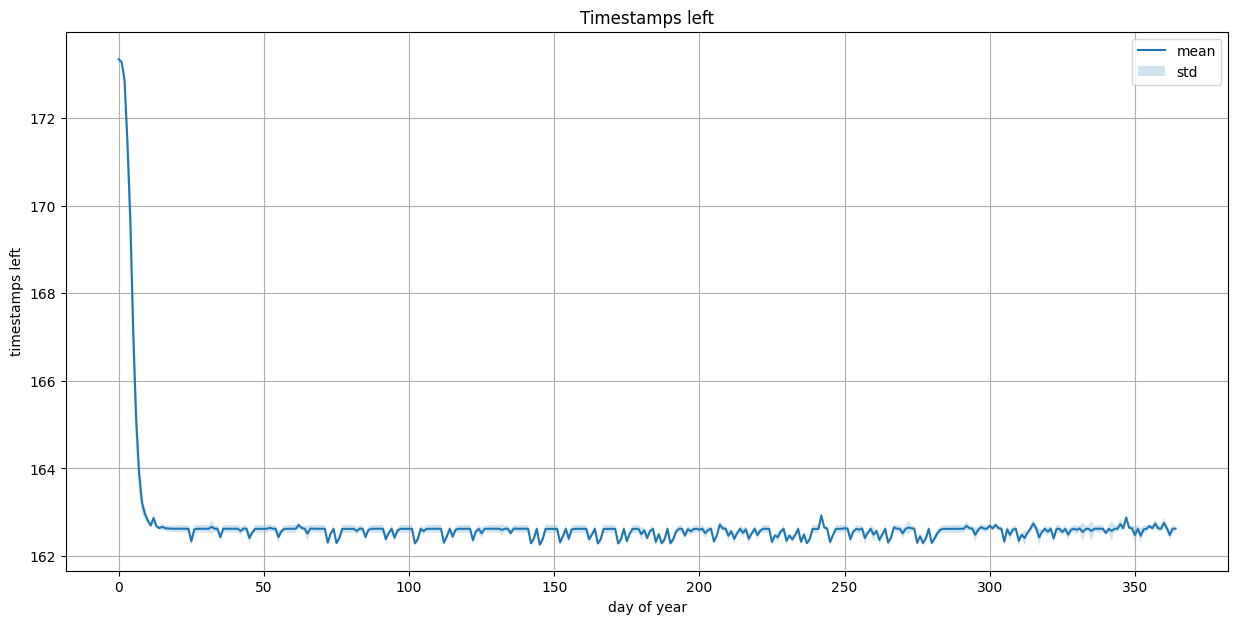

In [10]:
def plot_timestamps_left(stats, ax_timestamps, fig_timestamps):
    timestamps_left_mean = stats["timestamps_left"].mean(axis=0)
    timestamps_left_std = stats["timestamps_left"].std(axis=0)
    # plot mean and std
    ax_timestamps.plot(timestamps_left_mean, label="mean")
    ax_timestamps.fill_between(range(len(timestamps_left_mean)), timestamps_left_mean - timestamps_left_std,
                              timestamps_left_mean + timestamps_left_std, alpha=0.2, label="std")
    ax_timestamps.set_xlabel("day of year")
    ax_timestamps.set_ylabel("timestamps left")
    ax_timestamps.set_title("Timestamps left")
    ax_timestamps.legend()
    ax_timestamps.grid()
    
    return fig_timestamps, ax_timestamps


fig_timestamps, ax_timestamps = plt.subplots(figsize=(15, 7))
plot_timestamps_left(stats, ax_timestamps, fig_timestamps)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 

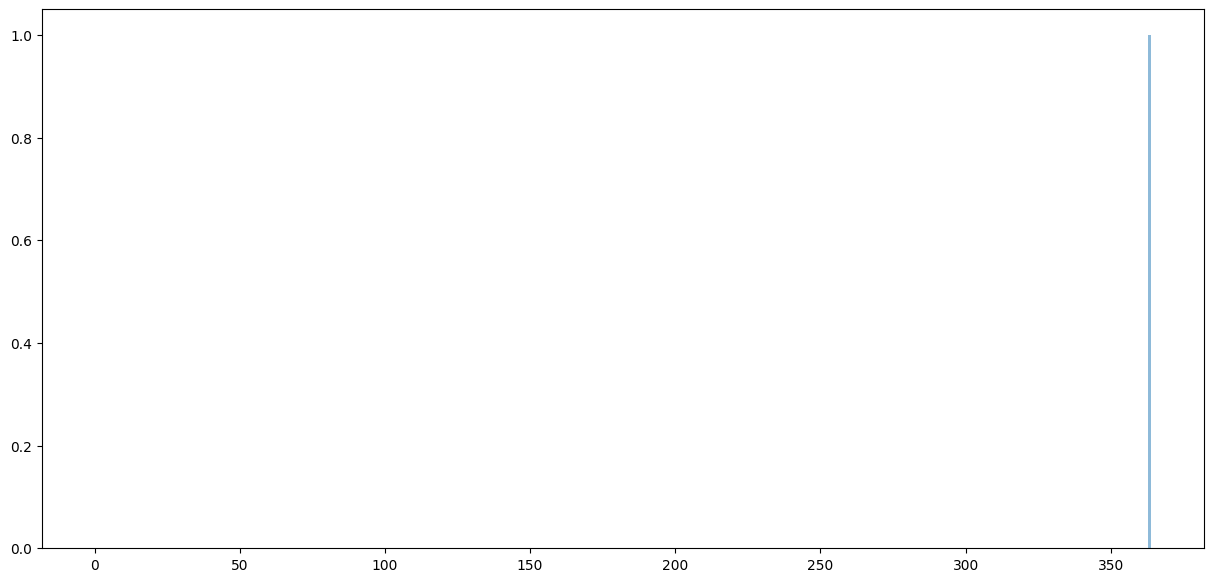

In [11]:
timestamps_left = stats["timestamps_left"]
# to torch tensor
timestamps_left = torch.from_numpy(timestamps_left)
t_stop = get_t_stop_from_daily_timestamps(timestamps_left, threshold=5)

# plot t_stop distribution
fig, ax = plt.subplots(figsize=(15, 7))
ax.hist(t_stop, bins=range(0, config.sequencelength), density=True, alpha=0.5, label="t_stop")

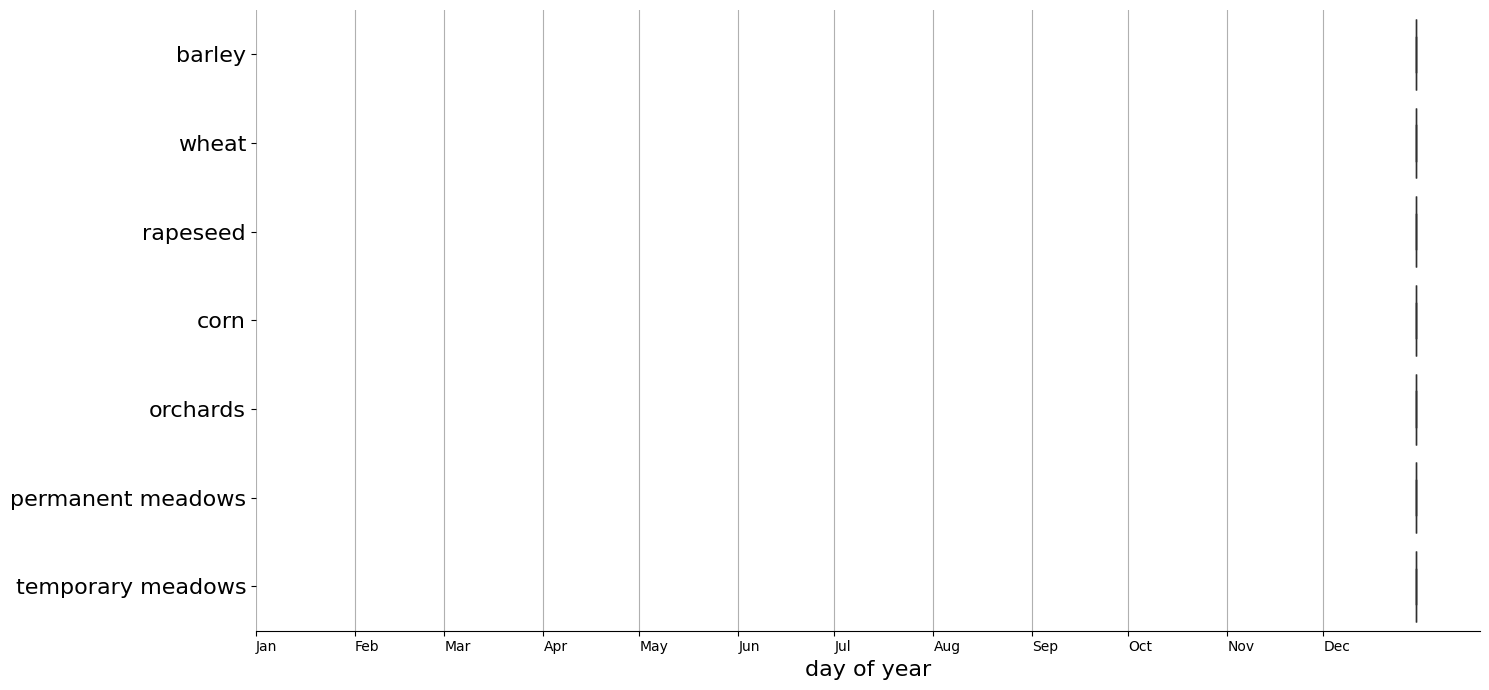

In [12]:
doys_stop = stats["t_stop"].squeeze()
fig_boxplot, ax_boxplot = plt.subplots(figsize=(15, 7))
fig_boxplot, _ = boxplot_stopping_times(doys_stop, stats, fig_boxplot, ax_boxplot, class_names)

In [14]:
# dummy test for get_t_stop_from_daily_timestamps
# create daily_timestamps tensor, with only zeros 
batchsize = 10
daily_timestamps = torch.zeros((batchsize, config.sequencelength), dtype=torch.float)
print("daily_timestamps", daily_timestamps)
t_stop = get_t_stop_from_daily_timestamps(daily_timestamps, threshold=5)
print("t_stop", t_stop)


daily_timestamps tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
t_stop tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
